# Integrantes:

* Germán Alonso Patiño Hurtado

* David Garcia Blandon

* David Andres Cano Gonzales

* Juan Pablo Buitrago Díaz 

# Objetivo de la competición

Las enzimas son proteínas que actúan como catalizadores en las reacciones químicas de los organismos vivos. El objetivo de esta competencia es predecir la termoestabilidad de las variantes enzimáticas.

## Librerias

In [2]:
# !pip install xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from itertools import chain, combinations, permutations
import sklearn.decomposition
import statsmodels.formula.api as smf
import tqdm as tq
# import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn.feature_selection
from xgboost import XGBRegressor
from scipy.stats import spearmanr

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals)

In [3]:
import matplotlib.pyplot as plt
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals)

    
# def periodo_letter(texto_:str, letter:str):
#     df_prueba=(pd.Series(list(texto_)))#.index
#     indices=df_prueba[df_prueba==letter].index
#     if len(indices)>2:
#         periodo=indices[1:]-indices[:-1]
#         periodo=sum(periodo)//len(periodo)
#     else:
#         periodo=0
#     return periodo

# def letter_periodo(df_:pd.DataFrame, column_:str,list_letter:list):
    
#     for letter in tq.tqdm(list_letter):
#         var_temp=df_[column_].apply(lambda x: periodo_letter(x, letter) ) 
#         df_ = pd.concat([df_, var_temp.rename("periodo"+letter)], axis=1)
    
#     return df_

def powerset_formulas(variables:list, response:str,left_,right_):
    """
    Genera la combinacion de formulas posibles de las variables hacia la variable respuesta
    para un modelo lm
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    variables: list de str.
    response: la variable respuesta en funcion de variables.
    return: list de formulas posibles con las variables.
    """
    comb_=list(chain.from_iterable(combinations(variables, r) for r in range(left_,right_+1  )))
    formulas=[response+"~"+"+".join(list(comb_[i])) for i in range(1,len(comb_))]
    return formulas

def count_letter(df_: pd.DataFrame, column_: str, list_letter:list):
    """
    
    """
    column_len=len(list(df_))
    for letter in tq.tqdm(list_letter):
        var_temp=(df_[column_].str.count(letter))#/df_["protein_length"]).copy() 
        df_ = pd.concat([df_, var_temp.rename(letter)], axis=1)
    return df_

def powerset(iterable):
    s = (iterable)
    return list(chain.from_iterable(permutations(s, r) for r in range(3)))

# def count_puentes(text_:str, pos1:str,pos2:str):
#     """
    
#     """

#     frecuencia=0
#     list_texto=list(text_)
#     for distancia in [4,5]:
#         posicion_1 =pd.Series(list_texto[distancia:],dtype="str" )
#         posicion_2= pd.Series(list_texto[:-distancia ],dtype="str")        
#         frecuencia=frecuencia+ sum(((posicion_1==pos1)  & (posicion_2==pos2) ) )
    
#     return frecuencia/len(text_)

# def puentes_hidrogeno(df_:pd.DataFrame,column_:str,posiciones_1:str, posiciones_2:str  ):
#     """
#     """
#     for posicion1 in posiciones_1:
#         for posicion2 in posiciones_2:
#             df_temp=df_[column_].apply(lambda x: count_puentes(x,posicion1,posicion2 ) ).copy()
#             df_=pd.concat([df_ , df_temp.rename(posicion1+"-"+posicion2)],axis=1)
#     return df_
    
list_letter=list("ARNDCEQGHILKMFPSTWYV")
list_words=["".join(list(x)) for x in powerset(list_letter)[1:]]
len(set(list_words))    



400

# Lectura de datos

En la descripción de la competencia se dan varias definciones de las base de datos que se tienen.

Como primer paso se realizara una limipeza de datos que se encuentra referencia:

https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356251


En ella se menciona que train.csv tiene problemas de datos faltantes y que no se a modificado, donde el train_updates_20220929.csv se usa para depurar la información.


In [4]:
df_train = pd.read_csv('train.csv',index_col="seq_id")
df_train_updates = pd.read_csv("train_updates_20220929.csv",index_col="seq_id")
filtro=df_train_updates.isnull().all("columns")
all_features_nan = (df_train_updates[filtro].index)
df_train=df_train.loc[~df_train.index.isin(list(all_features_nan))  ]
swap_ph_tm_indices = df_train_updates[~filtro].index
df_train.loc[swap_ph_tm_indices , ["pH", "tm"] ]=df_train_updates.loc[swap_ph_tm_indices , ["pH", "tm"] ]
df_train=df_train.loc[~df_train["pH"].isna(), ]

# temp = df_train_updates[df_train_updates["pH"] > -0.1]
# for i in range(len(temp)):
#     df_train[df_train.seq_id == temp.iloc[i].seq_id] = temp.iloc[i]

# df_train[['pH','tm']] = df_train[['tm','pH']].where(df_train['pH'] > 14, df_train[['pH','tm']].values)
# df_train.dropna(inplace=True)

In [5]:
df_train.shape

(28695, 4)

- El modelo se entrenara con 2,8695 proteinas.

In [6]:
df_train.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


- Las proteinas tienen un id (seq_id), una secuencia de enzimas, el pH, su termoestabilidad y la fuente de información.

- Para el modelo no se necesita la fuente de los datos, el objetivo es tm en funcion de la protein_sequence y pH.

- Existen 20 enzimas: A,R,N,D,C,E,Q,G,H,I,L,K,M,F,P,S,T,W,Y,V.

- Creamos el conteneo de enzimas en cada proteina.

- También se cuenta la cantidad de pares de enzimas, por ejemplo AR la frecuencia con que se repite, el nombre de las columnas son las letras y cada fila es la frecuencia en su propia frecuencia.

- Esto genera un total de 400 variables posibles adicionando el pH para predecir tm.

In [7]:
X = df_train[["tm",'protein_sequence', 'pH']].copy()
X['protein_length'] = X.protein_sequence.apply(lambda x: len(x))
X = count_letter(X, "protein_sequence",list_words)
X['protein_length'] = np.log(X['protein_length'])
X=X.drop(labels="protein_sequence",axis=1).copy()

100%|██████████| 400/400 [00:20<00:00, 19.13it/s]


La metodología de selección en el concurso es con la correlación de spearman entre las termoestabilidad real vs la predica, es decir, entre mas alto es mejor la predicción.

Se identifica las variable que puedan predecir tm a partir de la correlación 



<AxesSubplot:>

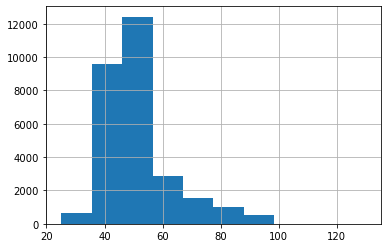

In [8]:
X["tm"].hist()

Podemos  observar la distribución de tm donde no hay una simetría, luego de transformar a escala log.

<AxesSubplot:>

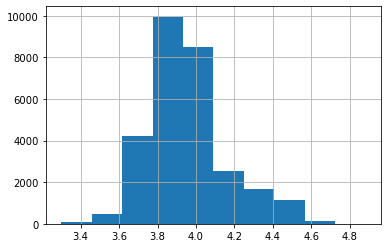

In [9]:
pd.Series(np.log(X["tm"]+2)).hist()

Se puede observar una mejor simetría en la variable respuesto, esto indica que puede ser una transformación apropiada, se crea la variable a escala log.

In [12]:
X["tm_log"]=np.log(X["tm"])
cor_temp=X.corr()
cor_temp_s=X.corr(method="spearman" )

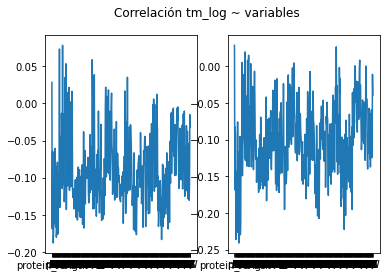

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Correlación tm_log ~ variables")
corr_tm=cor_temp.loc["tm",].iloc[1:-1]
ax1.plot(corr_tm) 
corr_tm_s=cor_temp_s.loc["tm",].iloc[1:-1]
ax2.plot(corr_tm_s)

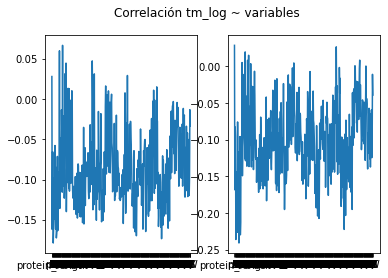

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Correlación tm_log ~ variables")
corr_tm_log=cor_temp.loc["tm_log",].iloc[1:-1]
ax1.plot(corr_tm_log) 
corr_tm_s_log=cor_temp_s.loc["tm_log",].iloc[1:-1]
ax2.plot(corr_tm_s_log) 

Para este caso se observa que las variables seleccionadas no alcanzan una alta con los dos metodos de correlación entre variables, por ende se opta por varios criterios de selección, donde hay correlación negatvia que parece ser <-0.2, este es una corte de referencia esto ocurre con la correlación de spearmen

In [31]:
(corr_tm_s[abs(corr_tm_s)>0.2].sort_values(ascending=False).index)

Index(['ST', 'KL', 'KS', 'I', 'D', 'T', 'C', 'SK', 'Q', 'S', 'N', 'K'], dtype='object')

In [25]:
corr_tm[abs(corr_tm_s_log)>0.2].sort_values(ascending=False).index

Index(['C', 'Q', 'ST', 'I', 'T', 'D', 'KL', 'S', 'KS', 'K', 'SK', 'N'], dtype='object')

Para este caso estas son unas posibles variables para tm.
- Otro metodo que se usara con la libreria sklearn, donde obtendremos un score de todas las variables. 

In [36]:

modelo_=sklearn.feature_selection.mutual_info_regression( X.drop(labels=["tm", "tm_log"],axis=1) ,X["tm"] )
score=pd.DataFrame(modelo_)
score.index=X.drop(labels=["tm", "tm_log"],axis=1).columns

In [41]:
score.sort_values(0,ascending=False ).head(10)

,0
protein_length,0.171655
pH,0.163166
S,0.135781
Q,0.128594
K,0.118098
I,0.115317
N,0.110004
C,0.107492
E,0.107231
D,0.105582


In [42]:
score.sort_values(0,ascending=False ).head(10).index

Index(['protein_length', 'pH', 'S', 'Q', 'K', 'I', 'N', 'C', 'E', 'D'], dtype='object')

Por medio de este metodo se escogen estas posibles variables que pueden explicar a tm.

In [46]:
variables_candidatas=['protein_length', 'pH', 'S', 'Q', 'K', 'I', 'N', 'C', 'E', 'D','ST', 
                      'KL', 'KS', 'I', 'D', 'T', 'C', 'SK', 'Q', 'S', 'N', 'K']
variables_candidatas=list(set(variables_candidatas))
np.array(variables_candidatas)

array(['KL', 'T', 'E', 'protein_length', 'S', 'I', 'pH', 'D', 'SK', 'KS',
       'ST', 'K', 'N', 'C', 'Q'], dtype='<U14')

In [48]:
len(variables_candidatas)

15

Se consideran estas variables para predecir tm, se plantean modelos de regresión lineal y transformando la variable a log, se realizan las posibles combinaciones de formulas con 10 a 15 variables, un total de 4943. La tranformación inversa es:

$$exp(tm+\hat\sigma/2 )$$

con $\hat\sigma$ el estimador de la desviación estandar de los errores, como el criterio de selección es la correlación de espearman se realiza validación cruzada y se realiza dicha predicción tomando la tranformación inversa y para los datos de prueba y entrenamiento se realiza la correlacipon de spearman.

In [164]:
formulas=powerset_formulas(variables_candidatas, "np.log(tm)", 10,15)
len(formulas)

4943

In [137]:
# X=X.drop(labels="tm_log", axis=1)
X_train, X_test, Y_train, Y_test= train_test_split(X,X["tm"],train_size=0.9,random_state=42)
list_corr_test=[]
list_corr_train=[]
for formula_ in tq.tqdm(formulas):
    modelo= smf.ols(formula_, data=X_train).fit()
    y_train_pred=np.exp(modelo.predict(X_train)+(modelo.scale**2)/2)
    y_test_pred=np.exp(modelo.predict(X_test)+(modelo.scale**2)/2)
    corr_test=pd.concat([Y_test,y_test_pred ] , axis=1)
    corr_test=corr_test.corr(method="spearman").iloc[0,1]
    list_corr_test.append(corr_test)
    corr_train=pd.concat([Y_train,y_train_pred ] , axis=1)
    corr_train=corr_train.corr(method="spearman").iloc[0,1]
    list_corr_train.append(corr_train)
    

100%|██████████| 14442/14442 [13:02<00:00, 18.47it/s]


In [165]:
# result=pd.DataFrame({"formula":formulas, "corr_train":list_corr_train, "corr_test": list_corr_test })
# result["error_corr"]=abs(result["corr_train"]-result["corr_test"])
# result.to_csv("correlacion_modelos5_7.csv",index=False )
result=pd.read_csv("correlacion_modelos.csv")
result.describe()

,corr_train,corr_test,error_corr
count,4943.000000,4943.000000,4.943000e+03
mean,0.250627,0.255830,8.483524e-03
std,0.012168,0.012653,6.211655e-03
min,0.208439,0.209110,1.229110e-07
25%,0.244348,0.247485,3.406297e-03
50%,0.253979,0.257050,7.319355e-03
75%,0.259320,0.265266,1.259656e-02
max,0.273904,0.284122,3.130284e-02


Luego esto es un resumen de las correlaciones obtenidas con los modelos ensayados, en este se puede observa que la mejor correlación entre los modelos es de 0.28, no se alcanzo una mayor correlación entre lo observado y predicho, pero hay una diferencia absoluta máxima de 0.03, esto es bueno ya que de todos los modelos parece que no se presento sobre ajuste con estos modelos.

In [167]:
posibles_modelos=result[(result["error_corr"] <0.02) & (result["corr_test"]>0.28 ) & (result["corr_train"]>0.26 ) ].sort_values("corr_test")#.tail(10)
posibles_modelos

,formula,corr_train,corr_test,error_corr
1469,np.log(tm)~KL+E+protein_length+S+D+SK+KS+ST+K+C,0.267897,0.280273,0.012376
4681,np.log(tm)~KL+E+protein_length+S+I+D+SK+KS+ST+...,0.267851,0.280286,0.012435
3774,np.log(tm)~KL+E+protein_length+S+I+D+SK+KS+ST+K+C,0.267946,0.280304,0.012358
3783,np.log(tm)~KL+E+protein_length+S+I+D+SK+ST+K+N+C,0.266072,0.280311,0.014240
1478,np.log(tm)~KL+E+protein_length+S+D+SK+ST+K+N+C,0.265780,0.280314,0.014534
3829,np.log(tm)~KL+E+protein_length+S+D+SK+KS+ST+K+N+C,0.267755,0.280316,0.012562
3185,np.log(tm)~KL+T+E+protein_length+S+D+SK+KS+ST+K+C,0.268339,0.280330,0.011991
4479,np.log(tm)~KL+T+E+protein_length+S+D+SK+KS+ST+...,0.268287,0.280335,0.012047
4424,np.log(tm)~KL+T+E+protein_length+S+I+D+SK+KS+S...,0.268418,0.280351,0.011933
1367,np.log(tm)~KL+E+protein_length+S+I+D+SK+ST+K+C,0.266099,0.280357,0.014258


Se realizan varios filtros y se piensa en estos posibles modelos.se selecciono este modelo: 'np.log(tm)~KL+T+E+protein_length+S+D+SK+ST+K+N+C'


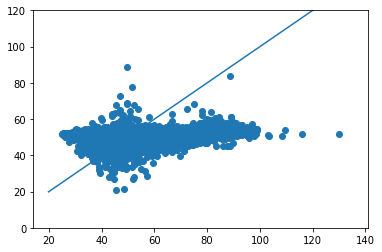

In [172]:
modelo= smf.ols(posibles_modelos.iloc[11,0], data=X_train).fit()
y_train_pred=np.exp(modelo.predict(X_train))#+(modelo.scale**2)/2)
y_test_pred=np.exp(modelo.predict(X_test))#+(modelo.scale**2)/2)
pred_train=pd.concat([Y_train,y_train_pred ] , axis=1)
pred_test=pd.concat([Y_test,y_test_pred ] , axis=1)
plt.scatter(x=pred_train["tm"],y=pred_train[0])
plt.ylim(0,120)
abline(1,0)

Con los datos de entrenamiento se observa que no es capaz de predecir correctamente a termoestabilidades altes, también se centra mucho en una sola media.

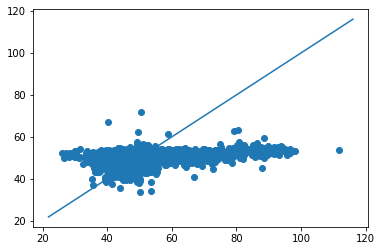

In [174]:
plt.scatter(x=pred_test["tm"],y=pred_test[0])
abline(1,0)

Para los datos de preuba sucede algo similar, con los modelos no se encontro un mejor modelo, se opta por usar arboles con el algoritmo de xgboost, en este caso se usan las variables candidatas:

In [210]:
xgb = XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=7)
xgb.fit(X_train[variables_candidatas],Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [211]:
pred_train_xgb=(xgb.predict(X_train[variables_candidatas]))
pred_test_xgb=(xgb.predict(X_test[variables_candidatas]))
pred_train_xgb=pd.concat([Y_train,pd.Series(pred_train_xgb,index=Y_train.index) ] , axis=1)
pred_test_xgb=pd.concat([Y_test,pd.Series(pred_test_xgb,index=Y_test.index) ] , axis=1)

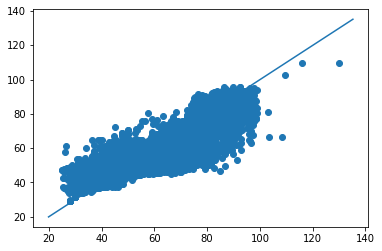

In [213]:
plt.scatter(x=pred_train_xgb["tm"],y=pred_train_xgb[0])
abline(1,0)

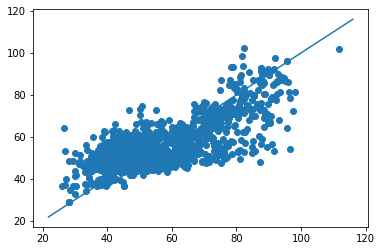

In [214]:
plt.scatter(x=pred_test_xgb["tm"],y=pred_test_xgb[0])
abline(1,0)

In [215]:
print("entrenamiento")
print(spearmanr(pred_train_xgb))
print("prueba")
print(spearmanr(pred_test_xgb))

entrenamiento
SpearmanrResult(correlation=0.7047530197708651, pvalue=0.0)
prueba
SpearmanrResult(correlation=0.5377395409330619, pvalue=7.580061236533967e-215)


Por medio de este metodo se observa que la correlación de spearman es mucho mayor que con los modelos de regresión, aunque claramente hay un sobre ajuste, este consigue mejores correlaciones que los modelos anteriores ya que como máximo se obtenia una correlación de 0.3, mientras que este para los datos de prueba llega a una correlación de 0.53, por esto se escoge el modelo de xgboost.

# Predicción final

Luego de observar los modelos xgboost y modelos de regresión se hace una predicción, se crean las variables y al final se realiza la predicción con ambos modelos, se obtiene un score por medio de los dos metodos.

In [216]:
df_test=pd.read_csv("test.csv")
df_test['protein_length'] = df_test.protein_sequence.apply(lambda x: len(x))
df_test = count_letter(df_test, "protein_sequence", list_words)
df_test['protein_length'] = np.log(df_test['protein_length'])

100%|██████████| 400/400 [00:01<00:00, 251.59it/s]


In [226]:
xgb = XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=7)
# xgb.fit(X[variables_candidatas],X["tm"])
xgb.fit(X_train[variables_candidatas],Y_train)
pred_test = xgb.predict(df_test[variables_candidatas])
submit_2=pd.DataFrame({"seq_id":df_test["seq_id"], "tm": pred_test })

<AxesSubplot:>

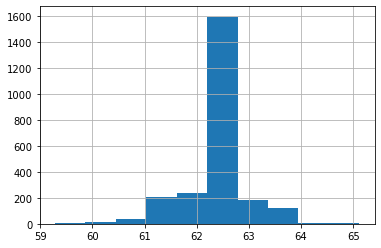

In [227]:
submit_2.tm.hist()

Esta es la predicción que se obtiene con los datos de testeo que se presentan en la competencia.

In [228]:
submit_2.to_csv("submit_xgb.csv",index=False)

In [230]:
modelo_final= smf.ols('np.log(tm)~KL+T+E+protein_length+S+D+SK+ST+K+N+C', data=X).fit()
pred_test_lm = np.exp(modelo_final.predict(df_test[variables_candidatas])+(modelo_final.scale**2)/2)
submit_lm=pd.DataFrame({"seq_id":df_test["seq_id"], "tm": pred_test_lm })

In [234]:
submit_lm.to_csv("submit_lm.csv",index=False)

El mejor modelo en este caso según ese score fue el modelo de regresión con transformación log

In [239]:
modelo_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             np.log(tm)   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     189.6
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:29:56   Log-Likelihood:                 4584.8
No. Observations:               28695   AIC:                            -9146.
Df Residuals:                   28683   BIC:                            -9046.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.1025      0.015    270.221      0.000       4.073       4.132
KL                -0.0078      0.001    -11.024      0.000      -0.009      -0.006
T                  0.0002      0.000      1.294      0.196      -0.000       0.001
E                  0.0026   9.73e-05     26.905      0.000       0.002       0.003
protein_length    -0.0284      0.003     -9.881      0.000      -0.034      -0.023
S              -6.081e-05      0.000     -0.607      0.544      -0.000       0.000
D                 -0.0010      0.000     -6.660      0.000      -0.001      -0.001
SK                -0.0047      0.001     -5.373      0.000      -0.006      -0.003
ST                -0.0041      0.001     -4.763      0.000      -0.006      -0.002
K                 -0.0015      0.000    -10.515      0.000      -0.002      -0.001
N                5.86e-05      0.000      0.394      0.693      -0.000       0.000
C                 -0.0010      0.000     -6.137      0.000      -0.001      -0.001
==============================================================================
Omnibus:                     1483.972   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1809.678
Skew:                           0.541   Prob(JB):                         0.00
Kurtosis:                       3.586   Cond. No.                     1.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

inicialmente se obtuvo un score de -0.115 y se logro una mejora a 0.088 y la mejora fue de 0.203.